In [1]:
import re
import json
import os
import shutil

from datetime import datetime
import IPython.display as ipd

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import datasets as hfd

import transformers
print(f'transformers version: "{transformers.__version__}"')

from transformers import (
    Wav2Vec2Processor, Wav2Vec2ProcessorWithLM,
    Wav2Vec2ForCTC,
    TrainingArguments, Trainer
)

import pyctcdecode

import torch
print(torch.cuda.is_available())

transformers version: "4.17.0"
True


In [2]:
from src.data_collator import DataCollatorCTCWithPadding
from src.metrics import WerMetricWithLM, parse_w2v2_predictions_batched_with_lm

In [3]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [4]:
# DATA_ROOT_DP = os.environ['DATA_HOME']
SSD_DATA_ROOT_DP = os.environ['SSD_DATA_HOME']

In [5]:
CV_PROCESSED_2_DP = f'{SSD_DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19__be__processed__2'

In [6]:
ds = hfd.load_from_disk(CV_PROCESSED_2_DP)
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 314305
    })
    dev: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15803
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15801
    })
})

## read model

In [7]:
processor = Wav2Vec2Processor.from_pretrained('artifacts/processor')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [9]:
pretrained_checkpoint_dp = 'train/run_2/2022-03-30-01-26-34/checkpoint-6480'
print(os.listdir(pretrained_checkpoint_dp))

['scheduler.pt', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'scaler.pt', 'config.json', 'rng_state.pth', 'optimizer.pt', 'trainer_state.json']


In [10]:
# continue from checkpoint
model = Wav2Vec2ForCTC.from_pretrained(pretrained_checkpoint_dp)

In [11]:
model.to('cuda');
model.device

device(type='cuda', index=0)

## prepare processor

In [12]:
vocab = processor.tokenizer.get_vocab()
pd.Series(vocab).sort_values().to_frame().T

,|,',i,а,б,в,г,д,е,ж,з,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,ы,ь,э,ю,я,ё,і,ў,[UNK],[PAD],<s>,</s>
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38


In [13]:
sorted_vocab_dict = [(char, ix) for char, ix in sorted(vocab.items(), key=lambda item: item[1])]
print(sorted_vocab_dict)

[('|', 0), ("'", 1), ('i', 2), ('а', 3), ('б', 4), ('в', 5), ('г', 6), ('д', 7), ('е', 8), ('ж', 9), ('з', 10), ('й', 11), ('к', 12), ('л', 13), ('м', 14), ('н', 15), ('о', 16), ('п', 17), ('р', 18), ('с', 19), ('т', 20), ('у', 21), ('ф', 22), ('х', 23), ('ц', 24), ('ч', 25), ('ш', 26), ('ы', 27), ('ь', 28), ('э', 29), ('ю', 30), ('я', 31), ('ё', 32), ('і', 33), ('ў', 34), ('[UNK]', 35), ('[PAD]', 36), ('<s>', 37), ('</s>', 38)]


In [14]:
lm_fp = 'artifacts/lm/cv8be_5gram.bin'

In [15]:
from pyctcdecode import build_ctcdecoder

decoder = build_ctcdecoder(
    labels=[x[0] for x in sorted_vocab_dict],
    kenlm_model_path=lm_fp,
)

2022-03-30 13:32:17,967:pyctcdecode.decoder:WARNING:Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
2022-03-30 13:32:17,967:pyctcdecode.alphabet:WARNING:Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
2022-03-30 13:32:17,967:pyctcdecode.language_model:WARNING:No known unigrams provided, decoding results might be a lot worse.


In [16]:
processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,
    tokenizer=processor.tokenizer,
    decoder=decoder
)

In [17]:
print(len(processor.tokenizer.get_vocab()))
print(sorted(processor.tokenizer.get_vocab()) == sorted(processor_with_lm.tokenizer.get_vocab()))
print(" ".join(sorted(processor_with_lm.tokenizer.get_vocab())))

39
True
' </s> <s> [PAD] [UNK] i | а б в г д е ж з й к л м н о п р с т у ф х ц ч ш ы ь э ю я ё і ў


In [18]:
print(len(processor_with_lm.decoder._alphabet.labels))
print(processor_with_lm.decoder._alphabet.labels)

39
[' ', "'", 'i', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'і', 'ў', '⁇', '', '<s>', '</s>']


In [19]:
print(len(processor_with_lm.decoder._idx2vocab))
print(processor_with_lm.decoder._idx2vocab)

39
{0: ' ', 1: "'", 2: 'i', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'й', 12: 'к', 13: 'л', 14: 'м', 15: 'н', 16: 'о', 17: 'п', 18: 'р', 19: 'с', 20: 'т', 21: 'у', 22: 'ф', 23: 'х', 24: 'ц', 25: 'ч', 26: 'ш', 27: 'ы', 28: 'ь', 29: 'э', 30: 'ю', 31: 'я', 32: 'ё', 33: 'і', 34: 'ў', 35: '⁇', 36: '', 37: '<s>', 38: '</s>'}


## evaluate model

In [20]:
wer_metrics = WerMetricWithLM(processor_with_lm=processor_with_lm)

In [21]:
training_args = TrainingArguments(
    output_dir='eval_output',
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metrics.compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [22]:
pred_out = trainer.predict(ds['test'])

***** Running Prediction *****
  Num examples = 15801
  Batch size = 48
/hdd2/data/aliaksandr_trafimau/.conda/envs/stt/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [24]:
pred_out.metrics

{'test_loss': 0.1495739370584488,
 'test_wer': 0.14581390287881615,
 'test_runtime': 555.8627,
 'test_samples_per_second': 28.426,
 'test_steps_per_second': 0.594}

In [26]:
print(f"WER on Test set using Acoustic Model + Language model: {pred_out.metrics['test_wer'] :.3f}")

WER on Test set using Acoustic Model + Language model: 0.146


### examples of model predictions

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1);

In [28]:
parsed_preds = parse_w2v2_predictions_batched_with_lm(pred_out, processor_with_lm=processor_with_lm)

In [31]:
df_results = pd.DataFrame(parsed_preds)[['text', 'pred_text']]
print(df_results.shape)

df_results['success'] = (df_results['text'] == df_results['pred_text']).astype('int')
df_results['wer'] = df_results.apply(
    lambda row: 
    wer_metrics.wer_metric.compute(
        predictions=[row['pred_text']],
        references=[row['text']]
    ),
    axis=1
)

df_results.head()

(15801, 2)


,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.000000
1,быў разбураны пры вызваленні горада ад нямецкафашысцкіх захопнікаў,быў разбураны пры вызваленні горада ад нямецкаю фашысцкіх захопнікаў,0,0.250000
2,далейшае супрацоўніцтва паміж нямецкім і савецкім прыняло форму абмену польскіх ваеннапалонных,далейшы супрацоўніцтва мічнямецкім савецкім прыняў формаў абмену польскіх ваеннаогам,0,0.636364
3,цвіценне працягваецца з мая да позняй восені,цвіценне працягваецца з мая да позняй восені,1,0.000000
4,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,1,0.000000


In [32]:
success_stats = df_results['success'].value_counts(dropna=False, normalize=True)
success_stats = success_stats.to_frame('fraction').join(
    df_results['success'].value_counts(dropna=False).rename('abs')
)
success_stats

,fraction,abs
0,0.532245,8410
1,0.467755,7391


In [33]:
print(f'Rate of fully recognized clips from Test set using Acoustic Model only: '
      f"{success_stats.loc[1, 'fraction'] :.3%}")

Rate of fully recognized clips from Test set using Acoustic Model only: 46.776%


In [34]:
df_results.sort_values('wer', ascending=False).head()

,text,pred_text,success,wer
1411,там спаткалі мяне насмешкамі здзекамі,табспаткалі мяне на смешкамі з зекамі,0,1.200000
2758,усё было так яскрава незабыўна,усё была так я скрава і за пэўным,0,1.200000
15154,вецер будзе паўночназаходні ўмеркаваны удзень слабы,вецер будзе паўночнага ходнік ў верггаварны у дзень ствала,0,1.166667
277,якім я вас упэўніваю бліжэй рокмузыка,асёнзанапацэўніі бляжаярокумузыка,0,1.000000
5675,міжаконныя прасценкі дэкарыраваны паўкалонамі з капітэлямі,вечаралонныя расцінкі дэкараваны па калонамі скапеітылені,0,1.000000


In [35]:
df_results.sort_values('wer', ascending=True).head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.0
8731,мы ім перашкаджалі а яны нам,мы ім перашкаджалі а яны нам,1,0.0
8732,буду да апошняга імкнуцца тут заставацца,буду да апошняга імкнуцца тут заставацца,1,0.0
8733,трэба каб яго пачулі як мага болей людзей,трэба каб яго пачулі як мага болей людзей,1,0.0
8737,знаходзіцца ў цэнтральнай частцы горада,знаходзіцца ў цэнтральнай частцы горада,1,0.0


In [37]:
df_results.sort_values('wer', ascending=True).sample(5)

,text,pred_text,success,wer
1086,мы гэта разумеем і яны разумеюць што мы гэта разумеем,мы гэта разумеем яны разумеюць што мы гэта разумеем,0,0.100000
13072,вецер ледзьледзь у коміне завывае,вецер ледзь ледзь у коміне забывае,0,0.600000
9957,фактычна мітрапаліт ўзяў яго пад сваю апеку,фактычна мітрапаліт узяў яго пад сваю апеку,0,0.142857
4625,на поўнач ад яго знаходзяцца міжнародны аэрапорт марскі курорт і навуковадаследчы цэнтр,на поўнач ад яго знаходзіцца міжнародны эрапорт марскі курорт і навукова даследчы цэнтр,0,0.333333
5035,па горах разбегліся алені серны суркі мядзведзі і многія іншыя жывёлы,па гарах разбегліся алені сермы суркі мядзведзі і многія іншыя жывёлы,0,0.181818


In [38]:
df_results.iloc[[12, 9532, 9533,12305]]

,text,pred_text,success,wer
12,толькі ў раёне таксама нашы людзі вясковыя,толькі ў раёне таксама наш людзі вясковая,0,0.285714
9532,у яго нават ёсць сольныя выступы,у яго нават ёсць сольныя выступы,1,0.000000
9533,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,1,0.000000
12305,шлюбам папярэднічалі перагаворы паміж сем'ямі,шлюбам папярэднічалі перагаворы паміж сем'ямі,1,0.000000


### wer stats for test set items

count    15801.000000
mean         0.141435
std          0.180414
min          0.000000
25%          0.000000
50%          0.090909
75%          0.230769
max          1.200000
Name: wer, dtype: float64

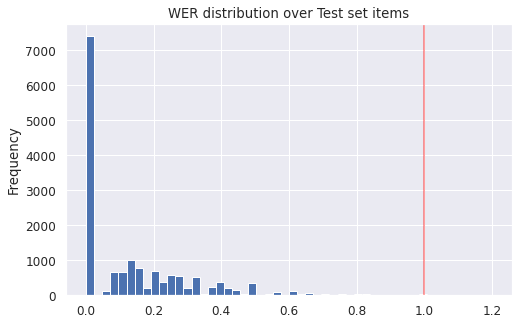

In [39]:
display(df_results['wer'].describe())

df_results['wer'].plot.hist(bins=50, figsize=(8, 5));
plt.title('WER distribution over Test set items');
plt.axvline(1, color='red', alpha=0.5);